<a href="https://colab.research.google.com/github/Pratyush1110/Machine-Learning/blob/main/HandsOnML/Chp3/Chp_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
X = X.to_numpy()
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

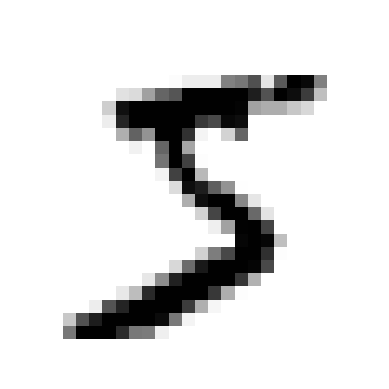

In [6]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

The above image looks like a 5 and if we check it's label, it is exactly that
even though it looks nothing like it tbh(weirdass s).

In [7]:
y[0]

'5'

Typecasting from string to integer, since we prefer to have numbers.

In [8]:
y = y.astype(np.uint8)

### Splitting into train set and test set.

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a binary classifier.
Let’s simplify the problem for now and only try to identify one digit—for example,
the number 5. This “5-detector” will be an example of a binary classifier, capable of
distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for
this classification task:


In [10]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

### Measuring Accuracy using Cross-Validation

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Above 95% accuracy! But, this is simply because only about 10% of the images are 5s anyways. Let's take a dumber model, i.e. BaseEstimator and try the same.

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
      pass
  def predict(self, X):
      return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

This clearly demonstrates that accuracy is not the preferred performance measure for classifiers, especially when dealing with skewed datasets(when some classes are much more frequent that the others).

### Confusion Matrix

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

53892 - not 5, predicted as not 5 (True Negatives)

687 - not 5, predicted as 5 (False Positives)

1891 - 5, predicted as not 5 (False Negatives)

3530 - 5, predicted as 5 (True Positives)

In [18]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

$$\text{Precision} = \frac{TP}{TP + FP}$$

$$\text{Recall} = \frac{TP}{TP + FN}$$

In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # Precision = 3530/(3530 + 687) = 0.837

0.8370879772350012

In [21]:
recall_score(y_train_5, y_train_pred) # Recall = 3530/(3530 + 1891) = 0.651

0.6511713705958311

F1 Score is the harmonic mean between Precision and Recall, since both of them have their shortcomings and can be cheated.

$$F_1 = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$$

In [22]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [26]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

By default, SGDClassifier uses a threshold = 0, anything above 0 (+ve) is classified as 5, while anything below 0 (-ve) is classified as not 5.

by changing the threshold, we can take control over the Precision/Recall tradeoff.

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

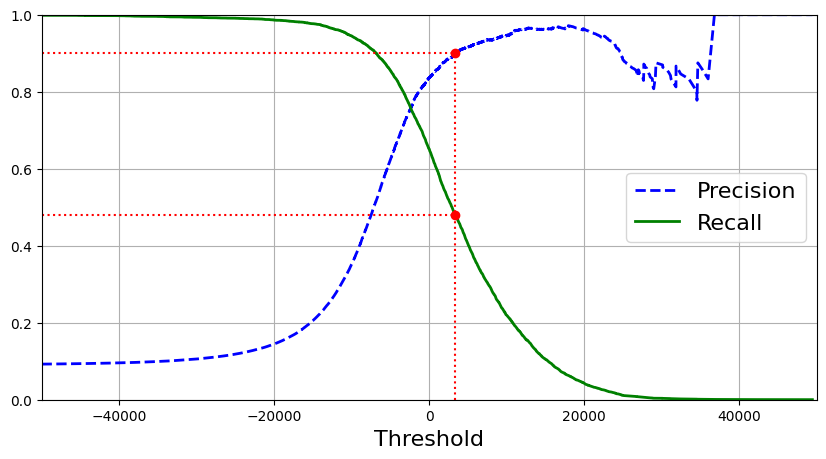

In [33]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    # Plot the main lines
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

    # Find the threshold for 90% precision to highlight it
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
    recall_90_precision = recalls[np.argmax(precisions >= 0.90)]

    # Add a vertical line and points to highlight the 90% precision mark
    plt.plot([threshold_90_precision, threshold_90_precision], [0, 0.9], "r:")
    plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
    plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
    plt.plot([threshold_90_precision], [0.9], "ro")
    plt.plot([threshold_90_precision], [recall_90_precision], "ro")

    # Labels, Legend, and Grid
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="center right", fontsize=16)
    plt.axis([-50000, 50000, 0, 1])
    plt.grid(True)

# Run the plot
plt.figure(figsize=(10, 5))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

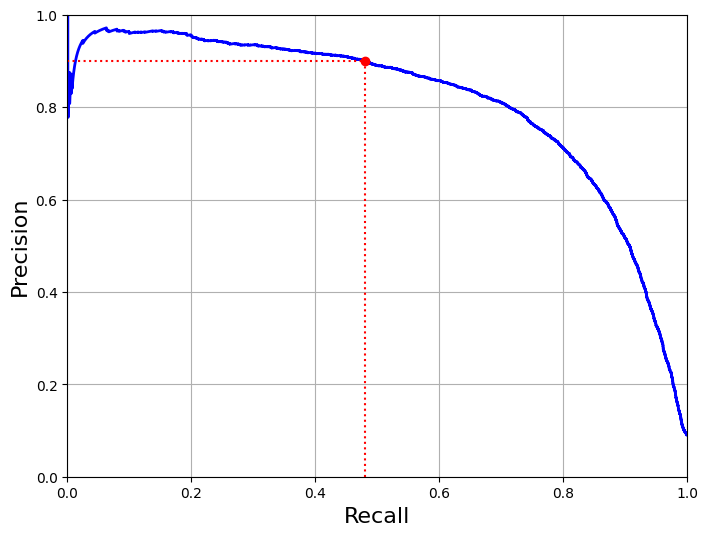

In [34]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)

# Let's highlight the same 90% precision point
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
plt.plot([recall_90_precision, recall_90_precision], [0, 0.9], "r:")
plt.plot([0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")

plt.show()

Let's say we are aiming for 90% precision.

In [36]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

np.float64(3370.0194991439557)

In [39]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [41]:
print("New Precision Score: ", precision_score(y_train_5, y_train_pred_90))
print("New Recall Score: ", recall_score(y_train_5, y_train_pred_90))

New Precision Score:  0.9000345901072293
New Recall Score:  0.4799852425751706


So, while we did increase precision from 83% to 90%, our recall went down from 65% to 47%.

This clearly highlights the Precision-Recall tradeoff, increasing one decreases the other and vice-versa.

They are inversely related.

But a high precision classifier is not very useful if the recall is too low!

### ROC Curve

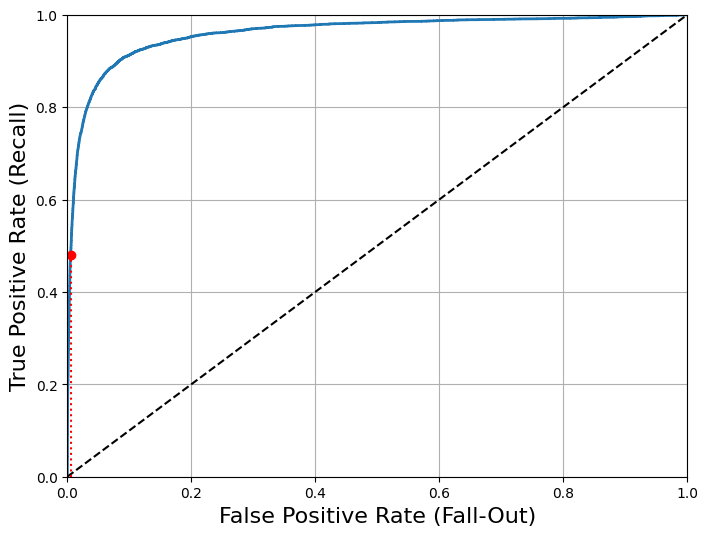

In [42]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal (random classifier)

    # Customizing the appearance
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)

# Let's highlight the point corresponding to our 90% precision threshold
# We find the index of the threshold we used earlier
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")

plt.show()

In [43]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [44]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

y_probas_forest returns a 2D array

column0 -> probability of image being not 5

column1 -> probability of image being 5

In [46]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

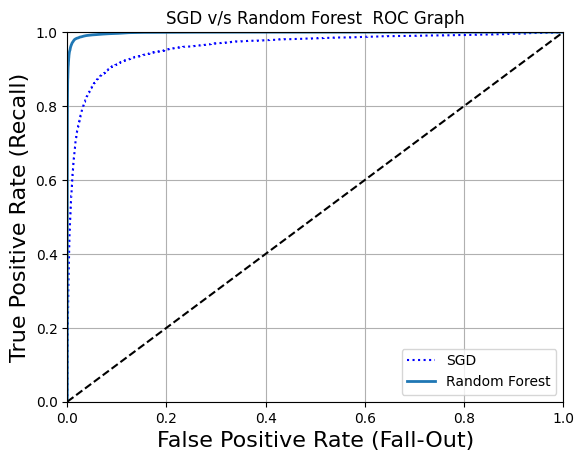

In [52]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.title("SGD v/s Random Forest  ROC Graph")
plt.show()

In [55]:
from sklearn.metrics import roc_auc_score

print("SGD AUC:", roc_auc_score(y_train_5, y_scores))
print("Random Forest AUC:", roc_auc_score(y_train_5, y_scores_forest))

SGD AUC: 0.9604938554008616
Random Forest AUC: 0.9983436731328145


Hence, we find that Random Forest is much better compared to SGD.

Measuring the precision recall scores should also give something like: 99% precision and 86.6% recall.

# Multiclass Classification

We can train 10 different binary classifiers for each digit, then choose the one which gives the highest score.

This is called the 'One-versus-All' strategy (OvA).

Another strategy is the 'OvO', i.e., One versus One. We train on pairs of digits.

In [56]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

when we ran **.fit()** with y_train, sklearn detected 10 recognized this as a multiclass problem, as it has 0-9 digits.

so, it trained 10 different binary classifiers => 1. "0-detector", 2. "1-detector", ... , "9-detector"

when asked to **.predict()**, it runs that image through all 10 classifiers, collectes decision scores from each, and picks the one with the highest decision score.

In [57]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [60]:
winning_index = np.argmax(some_digit_scores)
print(f"Winning index: {winning_index}")
print(f"Target class: {sgd_clf.classes_[winning_index]}")
print(sgd_clf.classes_)

Winning index: 3
Target class: 3
[0 1 2 3 4 5 6 7 8 9]


In [61]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [62]:
len(ovo_clf.estimators_)

45

we get 45 for OvO because 9+8+7+...+1 = 45

In [63]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [64]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

Random forest thinks there is 90% chance that the image is a 5, only 8% chance that is 3, and 1% each for 2 and 9.

Hence, it predicts 5.

In [65]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [67]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy", n_jobs=-1)

array([0.8983, 0.891 , 0.9018])

# Error Analysis

In [68]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

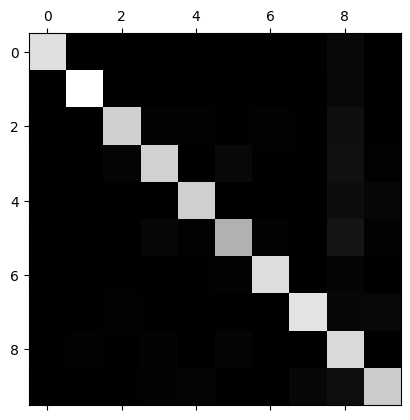

In [69]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

The white diagonal, means that the images were classified correctly majority of the time.

5 is slightly darker than 1, because 5 might be confused with 8 or 6 sometimes.

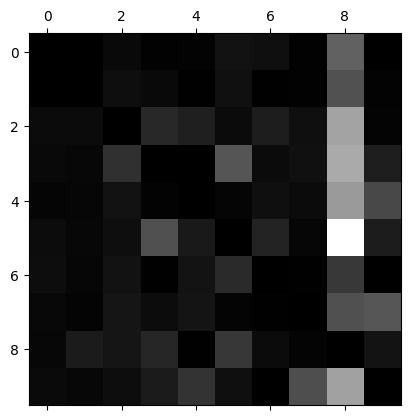

In [71]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

#black represents 0% error, white represents more error

Hence, we can conclude that:

**Many images get confused for begin 8.**

3s and 5s too often get confused.

We could try:

1. Gather more training data for digits that look like 8 (5 mostly).

2. Engineering more features that would help the classifier - for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has
none).

3. Preprocess the images (e.g., using Scikit-Image, Pillow, or
OpenCV) to make some patterns stand out more, such as closed loops.

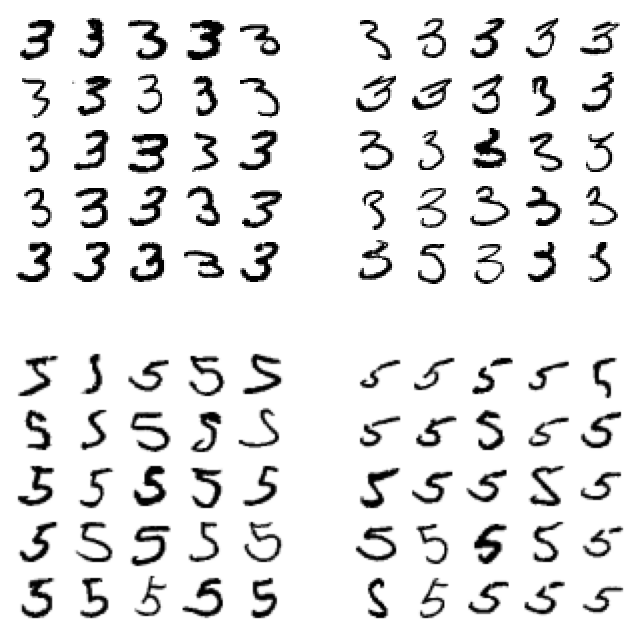

In [73]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1

    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    image_grid = padded_instances.reshape(n_rows, images_per_row, size, size)

    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)

    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

TopLeft -> 3s classfied as 3 (CORRECT)

TopRight -> 3s classified as 5 (INCORRECT)

BottomLeft -> 5s classified as 3 (INCORRECT)

BottomRight -> 5s classified as 5 (CORRECT)

# Multilabel Classification

In [74]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

This checks for 2 things, let's take 5 as an example:

1. y_train_large - is num >= 7?

2. y_train_odd - is num odd?

In [75]:
knn_clf.predict([some_digit])

array([[False,  True]])

5 is indeed not large -> False

5 is odd -> True

hence, returns [False, True]

In [76]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

# Multioutput Classification